# Fair Weather pedalers
** Weather's effect on bike share ridership on the Hubway system in Boston and its environs. **  
Kevin Burek &lt;<kburek@fas.harvard.edu>>, Joshua Mclellan &lt;<jvl.mclellan@gmail.com>>  
Harvard AM 207 Spring 2016 Final Project  

## Abstract
The Hubway bicycle share system serves riders in the urban core and near suburbs of Boston.  We'd like to discover something about the riders who use the system.  In 2013, the service providers released a dataset which we will analyze with respect to historical weather data, in order to explore the validity of different modeling hypotheses.  In brief, we believe that ridership may be composed of different constituencies, commuters and joyriders, which are affected differently by varying weather conditions.

## Tools
For analysis, we are using SciPy, NumPy, Pandas, PyMC, and Matplotlib.  
Some other core python libaries are coming along for the ride, too.

In [42]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import dateutil.parser as dtp

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

import string

## Data
The good folks at [Hubway](http://www.thehubway.com/) published the corpus of ridership logs from the system's inception in July 2011 through the end of the cycling season in 2013<sup>[[1]][@hubwaydatachallenge_zip]</sup>. For weather data, we turn to NOAA, whose [National Centers for Environmental Information](https://www.ncdc.noaa.gov/) provides the service of publishing [Climate Data Online](https://www.ncdc.noaa.gov/cdo-web/). We requested and received a data set including daily observed weather conditions for the relevant time period, for the Boston metropolitan area<sup>[[2]][@ncdc_boston]</sup>.


[@hubwaydatachallenge_zip]: http://files.hubwaydatachallenge.org/hubway_2011_07_through_2013_11.zip "Hubway Data Challenge. "hubway_2011_07_through_2013_11". Zip Archive. Retrieved 16 March 2016."

[@ncdc_boston]: http://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/locations/CITY:US250002/detail "NOAA National Centers for Environmental Information. "Daily Summaries Location Details: Boston, MA""

In [38]:
# Set a flag for whether to load the whole data set, or just a portion.
load_all = False
nb_root = ""
# Read ridership data
rides_path = "data/hubway_2011_07_through_2013_11/%shubway_trips.csv"
raw_rides = pd.read_csv(nb_root + rides_path % "") if load_all else pd.read_csv(nb_root + rides_path % "fewer_")
# Read weather data
weather_na = ("unknown", "9999", "-9999")
raw_weather = pd.read_csv(nb_root + "data/ncdc-2013.csv", na_values=weather_na)

raw_weather.head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,DATETIME,PRCP,PRCP Measurement Flag,PRCP Quality Flag,...,TMIN,TMIN Measurement Flag,TMIN Quality Flag,TMIN Source Flag,TMIN Time of Observation,TOBS,TOBS Measurement Flag,TOBS Quality Flag,TOBS Source Flag,TOBS Time of Observation
0,GHCND:USW00054704,NORWOOD MEMORIAL AIRPORT MA US,15.2,42.19083,-71.17361,20100101,2010-01-01T12:00,0.0,T,,...,-38.0,,,W,NaN,NaN,,,,NaN
1,GHCND:USW00054704,NORWOOD MEMORIAL AIRPORT MA US,15.2,42.19083,-71.17361,20100102,2010-01-02T12:00,23.0,,,...,-60.0,,,W,NaN,NaN,,,,NaN
2,GHCND:USW00054704,NORWOOD MEMORIAL AIRPORT MA US,15.2,42.19083,-71.17361,20100103,2010-01-03T12:00,5.0,,,...,-93.0,,,W,NaN,NaN,,,,NaN
3,GHCND:USW00054704,NORWOOD MEMORIAL AIRPORT MA US,15.2,42.19083,-71.17361,20100104,2010-01-04T12:00,0.0,,,...,-88.0,,,W,NaN,NaN,,,,NaN
4,GHCND:USW00054704,NORWOOD MEMORIAL AIRPORT MA US,15.2,42.19083,-71.17361,20100105,2010-01-05T12:00,0.0,,,...,-93.0,,,W,NaN,NaN,,,,NaN


In [3]:
weather = pd.DataFrame();
weather['STATION'] = raw_weather['STATION']
weather['DATE'] = raw_weather['DATE']
weather.set_index(['STATION', 'DATE'], drop=True, inplace=True)
weather['YEAR'] = [d[0:4] for d in raw_weather['DATE'].astype(np.str_)]
weather['MONTH'] = [d[4:6] for d in raw_weather['DATE'].astype(np.str_)]
weather['DAY'] = [d[6:] for d in raw_weather['DATE'].astype(np.str_)]
weather.head()


YEAR MONTH DAY
STATION           DATE                    
GHCND:USW00054704 20100101  2010    01  01
                  20100102  2010    01  02
                  20100103  2010    01  03
                  20100104  2010    01  04
                  20100105  2010    01  05

## Cleaning
Here we clean the data for analysis.  

### Augmenting ridership data
The ridership data has some properties that aren't well expressed in its current form. We calculate and add columns for the following extracted properties:  
* Start & End day of week (0/Monday - 6/Sunday) 
* Start & End time of day (00:00 - 23:59)
* ... Duration, rider age, ...

In [48]:
do_rebuild = True
ride_pickle_name = 'rides_pickle'
try:
    if do_rebuild: raise 'abort.';
    rides = pd.read_pickle(ride_pickle_name)
except:
    import dateutil.parser as dtp
    rides = raw_rides.copy()
    for endpoint in ('start', 'end'):
        %time datetimes = [dtp.parse(d) for d in rides[endpoint + '_date']]
        rides.loc[:,endpoint + '_datetime'] = pd.Series(datetimes, index = rides.index)
        rides.loc[:,endpoint + '_weekday'] = pd.Series([d.weekday() for d in datetimes], index = rides.index)
        rides.loc[:,endpoint + '_time'] = pd.Series([d.time() for d in datetimes], index = rides.index)
    
    rides.to_pickle(ride_pickle_name)




Wall time: 33.3 s
Wall time: 33.7 s


### Augmenting weather data
The raw weather data needs measurement flag columns renamed to associate them with the measurement dimensions they describe.  For now, we use pre-processed data.


# Formulating the likelihood
To generate a posterior predictive, we will eventually need
$$ P(\Theta | D) = \frac{P(D|\Theta)P(\Theta)}{P(D)} $$
The likelihood is a product over all of our ridership data $R$ and spread across heirarchical model components $L$ for each rental location:
$$ \mathscr{L} = P(D | \Theta) = \prod_R { \sum_L { p\left(t_d, w_d, \omega, s\ |\ \mu_t, \sigma_t, \lambda_d, c\right) } } $$

With data dimensions:  
$t_d$: Time of departure $\in$ $[$0/Midnight $\dots$ 43200/Noon $\dots$ 86400/Midnight$)$  
$w_d$: Weekday of departure $\in$ $\{$0/Monday $\dots$ 6/Sunday$\}$  
$\omega$: Weather quality $\propto {f}($temperature, sunlight, $\dots)$  
$s$: Subscription status $\in$ $\{0,1\}$

With model parameters:  
$\mu_t$: Mean time of departure $\in$ $[$0/Midnight $\dots$ 43200/Noon $\dots$ 86400/Midnight$)$  
$\sigma_t$: Deviation in time of departure $\in$ $[0,\infty)$  
$\lambda_w$: Ratio of weekday departures $\in$ $[0,1)$ such that $\left(\sum_{i=0}^{6}{\lambda_{w_i}}\right) = 1$  
$c$: Rider Commitment $\in$ $\{$0/Joyrider, 1/Commuter$\}$  


The likelihood is a beast.  First, we can write the location-likelihood as a linear function of the fair-weather likelihood:  
$$\mathscr{L}_L = \omega(\mathscr{L}_f) + b + \varepsilon$$
The fair-weather likelihood is a rat's nest of multinomials finally wrapping a normal:  
$$\mathscr{L}_f = (1-c)\left(\sum_d{\lambda_d\left(exp\left[\frac{-(t_d-\mu_{t_L})^2}{{\sigma_t}^2}\right]\right)}\right)\cdot c\left( \text{some mixture of gaussians?} \right)$$

## Labeling commitment on weekday rides

We will use expectation maximization to attempt recovery of the hidden commitment label $c$.

In [7]:
rides.head()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,start_datetime,start_weekday,start_time,end_datetime,end_weekday,end_time
0,1,8,Closed,9,7/28/2011 10:12:00,23,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male,2011-07-28 10:12:00,3,10:12:00,2011-07-28 10:12:00,3,10:12:00
1,2,9,Closed,220,7/28/2011 10:21:00,23,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male,2011-07-28 10:21:00,3,10:21:00,2011-07-28 10:25:00,3,10:25:00
2,3,10,Closed,56,7/28/2011 10:33:00,23,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male,2011-07-28 10:33:00,3,10:33:00,2011-07-28 10:34:00,3,10:34:00
3,4,11,Closed,64,7/28/2011 10:35:00,23,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female,2011-07-28 10:35:00,3,10:35:00,2011-07-28 10:36:00,3,10:36:00
4,5,12,Closed,12,7/28/2011 10:37:00,23,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female,2011-07-28 10:37:00,3,10:37:00,2011-07-28 10:37:00,3,10:37:00


(array([  74,  179,  329,  805, 1235, 1081, 1316, 1768, 2576, 2258, 1942,
       2641, 2038, 2105, 2028, 1558, 1374, 1728, 1382, 1478, 1381, 1262,
        946,  900, 1408,  833,  953,  881, 1318,  793,  580,  819, 1016,
        521,  718,  758,  564,  777,  527,  405,  293,  457,  282,  189,
        286,  181,  150,  202,  114,  125,   41,   23,   54,    5,   27,
         14,   13,    0,    0,    0,    0,    5], dtype=int64), array([ 17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,
        28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,
        39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,
        50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
        61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
        72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.]))


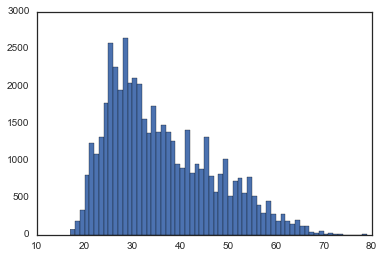

In [79]:
rides = rides.dropna()
ages = [d.year for d in rides['start_datetime']] - rides['birth_date']

nbins = np.max(ages) - np.min(ages)
print np.histogram(ages, bins=nbins)
plt.hist(ages, bins=nbins)
plt.show()


79.0


35.6460395048


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan]))

In [81]:
28.78*1.18

33.9604